# ML Project: _Dataset Proposals_

---

## **Part 1:** _Automatically Evaluate Dataset & Generate Algorithm-Selection Graph_

This module implements an automatic algorithm selection strategy inspired by
the scikit‑learn cheat‑sheet. It evaluates a given dataset to determine if the
problem is supervised (and, if so, whether it is classification or regression) or unsupervised (clustering or dimensionality reduction) and builds a decision flow graph that explains every decision made.

![](https://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png)

### 1.1 Imports & Setup

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from enum import Enum, auto
from typing import List, Optional, Literal

import pandas as pd
import numpy as np

In [ ]:
# 1.  High-level enums / dataclasses
class Problem(Enum):
    CLASSIFICATION = auto()
    REGRESSION = auto()
    CLUSTERING = auto()
    DIM_REDUCTION = auto()
    INSUFFICIENT_DATA = auto()


@dataclass(slots=True)
class DatasetMeta:
    n_samples: int
    n_features: int
    has_target: bool
    target_is_categorical: bool
    has_text_features: bool


@dataclass(slots=True)
class Recommendation:
    problem: Problem
    algorithms: List[str]
    rationale: str


In [ ]:
# 2.  Core selector
class CheatSheetSelector:
    """
    Recommends scikit-learn algorithms based on data characteristics,
    following the official cheat-sheet flow for supervised (classification/regression)
    and unsupervised (clustering/dimensionality reduction) problems.
    """

    MIN_SAMPLES           = 50       # minimum samples for supervised methods
    CLUSTER_SAMPLE_LIMIT  = 10_000   # threshold for clustering/manifold methods
    SUPERVISED_SAMPLE_LIMIT = 100_000  # threshold for scalable supervised methods
    FEW_FEATURES_LIMIT    = 10       # threshold for sparse linear regression

    def __init__(
        self,
        df: pd.DataFrame,
        target_col: Optional[str] = None,
        n_clusters: Optional[int] = None,
        unsup_type: Optional[Literal["cluster", "reduce"]] = None,
    ):
        self.df = df
        self.target_col = target_col if target_col in df.columns else None
        self.n_clusters = n_clusters
        self.unsup_type = unsup_type
        self.meta = self._infer_meta()

    def recommend(self) -> Recommendation:
        m = self.meta

        # 1. too few samples?
        if m.n_samples < self.MIN_SAMPLES:
            return Recommendation(
                Problem.INSUFFICIENT_DATA,
                ["Collect more data"],
                f"{m.n_samples} < {self.MIN_SAMPLES} samples.",
            )

        # 2. Supervised?
        if m.has_target:
            if m.target_is_categorical:
                return self._classification()
            return self._regression()

        # 3. Unsupervised?
        if self.unsup_type == "reduce":
            return self._dimension_reduction()
        return self._clustering()

    def _classification(self) -> Recommendation:
        m = self.meta

        # Text data → MultinomialNB; fallback to KNN → SVC ensemble
        if m.has_text_features:
            return Recommendation(
                Problem.CLASSIFICATION,
                [
                    "MultinomialNB",
                    "KNeighborsClassifier",
                    "SVC(kernel='rbf') / EnsembleClassifiers",
                ],
                "Text features → MultinomialNB; fallback to KNN → SVC ensemble.",
            )

        # Numeric data → LinearSVC if <100K samples, else SGDClassifier
        if m.n_samples < self.SUPERVISED_SAMPLE_LIMIT:
            primary = "LinearSVC"
            rationale = f"{m.n_samples} < {self.SUPERVISED_SAMPLE_LIMIT} → LinearSVC."
        else:
            primary = "SGDClassifier"
            rationale = f"{m.n_samples} ≥ {self.SUPERVISED_SAMPLE_LIMIT} → SGDClassifier."

        # Fallback chain: kernel approximation → KNN → SVC ensemble
        algos = [
            primary,
            "KernelApproximation",
            "KNeighborsClassifier",
            "SVC(kernel='rbf') / EnsembleClassifiers",
        ]

        return Recommendation(
            Problem.CLASSIFICATION,
            algos,
            f"{rationale} Fallback: kernel approximation → KNN → SVC ensemble.",
        )


    def _regression(self) -> Recommendation:
        m = self.meta

        # ≥100K samples → SGDRegressor
        if m.n_samples >= self.SUPERVISED_SAMPLE_LIMIT:
            return Recommendation(
                Problem.REGRESSION,
                ["SGDRegressor"],
                f"{m.n_samples} ≥ {self.SUPERVISED_SAMPLE_LIMIT} → SGDRegressor.",
            )

        # <100K samples & few features → ElasticNet/Lasso
        if m.n_features <= self.FEW_FEATURES_LIMIT:
            return Recommendation(
                Problem.REGRESSION,
                ["ElasticNet", "Lasso"],
                (
                    f"{m.n_samples} < {self.SUPERVISED_SAMPLE_LIMIT} & "
                    f"{m.n_features} ≤ {self.FEW_FEATURES_LIMIT} features → ElasticNet/Lasso."
                ),
            )

        # <100K samples & many features → RidgeRegression/SVR(linear); fallback to SVR(rbf)/ensemble
        return Recommendation(
            Problem.REGRESSION,
            [
                "RidgeRegression",
                "SVR(kernel='linear')",
                "SVR(kernel='rbf') / EnsembleRegressors",
            ],
            (
                f"{m.n_samples} < {self.SUPERVISED_SAMPLE_LIMIT} & "
                f"{m.n_features} > {self.FEW_FEATURES_LIMIT} features → "
                "RidgeRegression/SVR(linear); fallback to SVR(kernel='rbf') / ensemble."
            ),
        )


    def _clustering(self) -> Recommendation:
        m = self.meta
        known_k = self.n_clusters is not None

        # user knows k → KMeans family
        if known_k:
            if m.n_samples < self.CLUSTER_SAMPLE_LIMIT:
                return Recommendation(
                    Problem.CLUSTERING,
                    ["KMeans", "SpectralClustering", "GaussianMixture"],
                    f"{m.n_samples} < {self.CLUSTER_SAMPLE_LIMIT} & known k → "
                    "KMeans; fallback to SpectralClustering/GMM.",
                )
            return Recommendation(
                Problem.CLUSTERING,
                ["MiniBatchKMeans"],
                f"{m.n_samples} ≥ {self.CLUSTER_SAMPLE_LIMIT} & known k → MiniBatchKMeans.",
            )

        # unknown k → density/mixture methods or none
        if m.n_samples < self.CLUSTER_SAMPLE_LIMIT:
            return Recommendation(
                Problem.CLUSTERING,
                ["MeanShift", "BayesianGaussianMixture"],
                f"{m.n_samples} < {self.CLUSTER_SAMPLE_LIMIT} & unknown k → "
                "MeanShift; fallback to VB-GMM.",
            )

        # too many samples & unknown k → no good option
        return Recommendation(
            Problem.CLUSTERING,
            [],
            f"{m.n_samples} ≥ {self.CLUSTER_SAMPLE_LIMIT} & unknown k → no recommended clustering.",
        )


    def _dimension_reduction(self) -> Recommendation:
        m = self.meta

        # <10K samples → RandomizedPCA; fallback to manifold methods (Isomap/SpectralEmbedding; then LLE)
        if m.n_samples < self.CLUSTER_SAMPLE_LIMIT:
            algos = [
                "RandomizedPCA",
                "Isomap",
                "SpectralEmbedding",
                "LocallyLinearEmbedding",
            ]
            rationale = (
                f"{m.n_samples} < {self.CLUSTER_SAMPLE_LIMIT} → RandomizedPCA; "
                "fallback to Isomap/SpectralEmbedding; fallback to LLE."
            )
        # ≥10K samples → kernel approximation
        else:
            algos = ["KernelApproximation"]
            rationale = f"{m.n_samples} ≥ {self.CLUSTER_SAMPLE_LIMIT} → KernelApproximation."

        return Recommendation(
            Problem.DIM_REDUCTION,
            algos,
            rationale,
        )


    def _infer_meta(self) -> DatasetMeta:
        df, tgt = self.df, self.target_col
        n_samples = len(df)
        features = [c for c in df.columns if c != tgt]
        n_features = len(features)
        has_target = tgt is not None

        target_is_categorical = False
        if has_target:
            y = df[tgt]
            target_is_categorical = (
                not pd.api.types.is_numeric_dtype(y) or y.nunique() <= 10
            )

        has_text_features = any(
            pd.api.types.is_string_dtype(df[c])
            or isinstance(df[c].dtype, pd.CategoricalDtype)
            for c in features
        )

        return DatasetMeta(
            n_samples=n_samples,
            n_features=n_features,
            has_target=has_target,
            target_is_categorical=target_is_categorical,
            has_text_features=has_text_features,
        )

    def __repr__(self) -> str:
        rec = self.recommend()
        algs = ", ".join(rec.algorithms) or "none"
        return f"<CheatSheetSelector problem={rec.problem.name} algos=[{algs}]>"


---

---
Example usage (testing)

In [4]:
import pandas as pd

# toy dataset
df = pd.DataFrame(
    {
        "txt": ["spam", "ham"] * 300,
        "feat": range(600),
        "y":   [0, 1] * 300,
    }
)

selector = CheatSheetSelector(df, target_col="y")
rec = selector.recommend()

print("Problem type :", rec.problem.name)
print("Suggested algos :", ", ".join(rec.algorithms))
print("Why            :", rec.rationale)


Problem type : CLASSIFICATION
Suggested algos : MultinomialNB, LogisticRegression
Why            : text features detected → classic text classifiers


---

### 1.2 Real Dataset Example using kagglehub

In [5]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

In [6]:
# Helper – load a CSV from a Kaggle repo into a DataFrame
def load_csv_from_kaggle(
    repo: str,
    csv_name: str,
    pandas_kwargs: dict | None = None,
) -> pd.DataFrame:
    """Download *csv_name* from Kaggle *repo* into a DataFrame."""
    return kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        repo,
        csv_name,
        pandas_kwargs=pandas_kwargs or {},
    )


def pretty_print(rec: Recommendation) -> None:
    print(f"\nProblem       : {rec.problem.name}")
    print(f"Algorithms    : {', '.join(rec.algorithms)}")
    print(f"Rationale     : {rec.rationale}\n")

#### **Deutsche Bahn Delays** - Automatic Algorithm Selection

In [7]:
df_db = load_csv_from_kaggle(
    "nokkyu/deutsche-bahn-db-delays",
    "DBtrainrides.csv",
)


<ipython-input-6-acc66452fc0b>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  return kagglehub.load_dataset(


In [ ]:
# Deutsche Bahn Dataset - Delay Duration Prediction
selector_db = CheatSheetSelector(df_db, target_col="arrival_delay_m")
rec_db = selector_db.recommend()

print("=== Deutsche Bahn Delays (duration) ===")
pretty_print(rec_db)


=== Deutsche Bahn Delays ===

Problem       : REGRESSION
Algorithms    : SGDRegressor
Rationale     : 2061357 samples ≥ 100000 → scalable SGD



In [ ]:
# Deutsche Bahn Dataset - Delay Occurrence Prediction
selector_db_occ = CheatSheetSelector(df_db, target_col="departure_delay_check")
rec_db_occ = selector_db_occ.recommend()

print("=== Deutsche Bahn Delays (occurrence) ===")
pretty_print(rec_db_occ)

#### **Global Terrorism Database** - Automatic Algorithm Selection

In [9]:
df_gtd = load_csv_from_kaggle(
    "START-UMD/gtd",
    "globalterrorismdb_0718dist.csv",
    pandas_kwargs={"encoding": "ISO-8859-1"},
)


<ipython-input-6-acc66452fc0b>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  return kagglehub.load_dataset(
/usr/local/lib/python3.11/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


In [10]:
# Global Terrorism Database – *binary classification* example
selector_gtd = CheatSheetSelector(df_gtd, target_col="property")
rec_gtd = selector_gtd.recommend()

print("=== Global Terrorism Database ===")
pretty_print(rec_gtd)

=== Global Terrorism Database ===

Problem       : CLASSIFICATION
Algorithms    : MultinomialNB, LogisticRegression
Rationale     : text features detected → classic text classifiers



In [11]:
# Global Terrorism Database – *unsupervised* example (drop target)
selector_gtd_unsup = CheatSheetSelector(df_gtd.drop(columns=["property"]))
rec_gtd_unsup = selector_gtd_unsup.recommend()

print("=== GTD – Unsupervised variant ===")
pretty_print(rec_gtd_unsup)

=== GTD – Unsupervised variant ===

Problem       : DIM_REDUCTION
Algorithms    : RandomizedPCA, TruncatedSVD
Rationale     : large dataset → randomized linear DR



## **Part 2:** Selected Dataset - Targeted estimation

### **Deutsche Bahn Delays** - Predicting Delay Occurrence and Duration

#### **Dataset Overview**

We will utilize the **"Deutsche Bahn Delays"** dataset provided by [nokkyu](https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays) to predict train delays in Germany. The dataset consists of hourly snapshots of planned train arrivals and departures, along with actual arrival and departure times, recorded delays, geographical data, and additional metadata like station categories and train lines.

**Key features include:**
- Planned vs. actual arrival/departure times
- Delay durations (minutes)
- Station geolocation
- Station categories (main junctions to small stations)
- Train lines and paths

#### **Project Objectives**

This project aims to build a hybrid machine learning model capable of:
1. **Classifying** whether a train will experience a delay (binary classification).
2. **Estimating** the duration of delays when they occur (regression).

#### **Methodology**

We propose the following two-step modeling pipeline:

**Step 1: Delay Occurrence Prediction**  
- Target: `departure_delay_check` ("on_time" or "delay")
- Model: `SGDClassifier` or a similar binary classifier.

**Step 2: Delay Duration Prediction**  
- Target: `departure_delay_m` (numerical minutes of delay)
- Model: `SGDRegressor` (efficient, scalable, suitable for large datasets)

#### **Loading The Data**

In [12]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "DBtrainrides.csv"

# Load the latest version
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "nokkyu/deutsche-bahn-db-delays",
    file_path
)

<ipython-input-12-f96011839292>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
print(df.head())


#### **Exploratory Data Analysis & Visualization**

To understand and visualize delay patterns, the following analyses will be conducted:

1. **Temporal Patterns:**
   - Line plots showing average delays over different hours of the day.
   - Heatmap visualizations to identify peak delay hours.

2. **Geographical Patterns:**
   - Map-based visualizations showing hotspots of frequent and prolonged delays.

3. **Station Category Analysis:**
   - Distribution of delays by station categories (e.g., large junctions vs. smaller stations).

#### **Dataset Visualizations**

---

**Temporal Patterns**

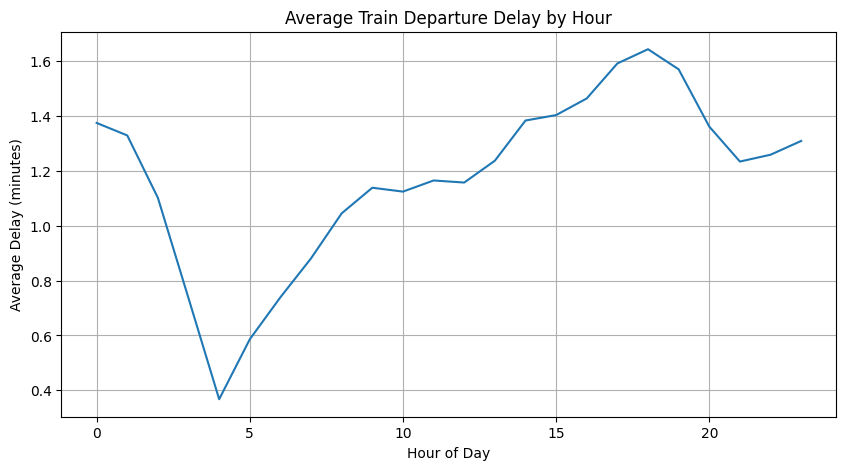

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'departure_plan' to datetime
df['departure_plan'] = pd.to_datetime(df['departure_plan'])

# Average delays by hour
hourly_delay = df.groupby(df['departure_plan'].dt.hour)['departure_delay_m'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_delay.index, y=hourly_delay.values)
plt.title('Average Train Departure Delay by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()

---

**Geographical Patterns**

In [15]:
import plotly.express as px

station_delay = df.groupby(['station', 'lat', 'long']).departure_delay_m.mean().reset_index()

fig = px.scatter_mapbox(
    station_delay, lat='lat', lon='long', size='departure_delay_m',
    hover_name='station', color='departure_delay_m', size_max=15,
    center={"lat": 49.4, "lon": 11.5},
    zoom=5, mapbox_style="carto-positron",
    title="Average Departure Delay by Station in Germany"
)
fig.show()

#### **Modeling Approach**

The data will be split into training (80%) and testing (20%) sets. Features like `time`, `station`, `line`, `category`, and geographical coordinates (`lat`, `long`) will be preprocessed using standard scaling, encoding, and feature selection.

In [16]:
# TODO: Implementation of the dataset

#### **Evaluation Metrics**

- **Classification:** Accuracy, Precision, Recall, ROC-AUC
- **Regression:** Mean Absolute Error (MAE), Mean Squared Error (MSE), R-squared (R²)

### **Bike Traffic in Munich** - Predicting bike traffic based on weather and date.

#### **Dataset overview**

We will use the dataset provided by [lucafrance](https://www.kaggle.com/datasets/lucafrance/bike-traffic-in-munich).

This dataset is based on data collected from six bicycle counting stations across the city of Munich. Each station records the number of cyclists passing by daily, along with key weather conditions. For this study, we focus on the **daily aggregated dataset**, which includes:

- **Total daily bicycle traffic per station**
- **Weather information**, including minimum and maximum temperatures and daily precipitation
- **Date** in `YYYY.MM.DD` format

The main goal of the project is to **predict the total number of cyclists per day** based on weather conditions and calendar-related features derived from the date (such as the day of the week or month). This can help in understanding how environmental and temporal factors influence urban cycling behavior.

The dataset provides consolidated information starting from **January 2017**, offering a robust time frame for building and evaluating predictive models.

#### **Project Objectives**

This project aims to build a hybrid machine learning model capable of:
- *Estimating*: the total number of bikes in a day (regression)

#### **Methodology**

The goal of this project is to predict the total number of cyclists per day based on weather conditions and temporal features derived from the date. The methodology involves the following modeling pipeline:

- **Target Column:** The target variable is the **total number of cyclists per day** (`gesamt`).
  
- **Model Selection:** A **Linear Regression model** will be used for this regression task due to its simplicity and efficiency in capturing linear relationships between the predictors (weather conditions and temporal features) and the target variable.

- **Alternative Models:** If necessary, more advanced models such as **Random Forest Regressor** or **Gradient Boosting Regressor** could be explored to capture non-linear patterns and improve predictive accuracy.

This approach will allow us to predict daily bike traffic based on the weather and time-related factors, aiding in the understanding of how these variables influence urban cycling behavior.

#### **Loading the data**

In [17]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "rad_tage.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lucafrance/bike-traffic-in-munich",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# print(df.head())

<ipython-input-17-3bd4ae1aca7e>:10: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.



100%|██████████| 1.07M/1.07M [00:00<00:00, 2.67MB/s]


#### **Exploratory Data Analysis & Visualization**

To gain insights into the patterns of bike traffic in Munich, various exploratory analyses and visualizations will be conducted:

1. **Temporal Patterns:**
    - **Scatter plot** showing the relationship between the maximum temperature and total cyclist count across different stations. This will help us understand how weather conditions, particularly temperature, correlate with bike traffic.
    - **Correlation heatmap** of weather-related features (e.g., minimum and maximum temperature, precipitation, cloud cover, and sunshine hours) along with the total cyclist count. This will reveal how strongly each weather variable influences the overall bike traffic.

2. **Station-Based Patterns:**
    - **Pairplot** to explore the relationship between key weather features (sunshine hours, precipitation, cloud cover, etc.) and the total cyclist count across different stations. The visualization will be color-coded by station, providing insights into station-specific traffic patterns and how weather conditions vary across locations.

These visualizations will offer a deeper understanding of how bike traffic varies with weather conditions, time, and across different measuring stations.

#### **Data visualization**

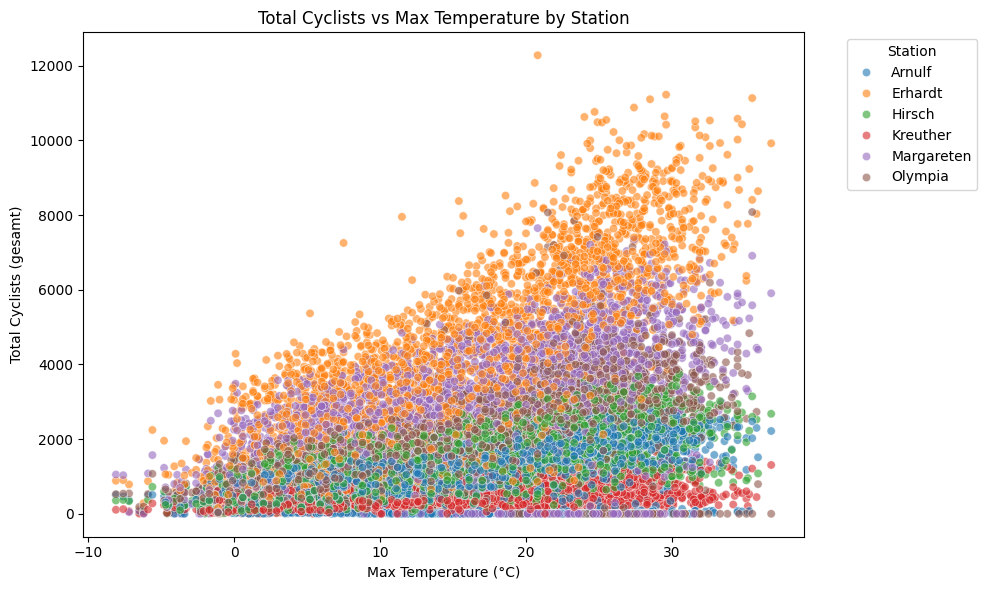

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert date column
df['datum'] = pd.to_datetime(df['datum'], format='%Y.%m.%d')

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='max-temp', y='gesamt', hue='zaehlstelle', alpha=0.6)
plt.title("Total Cyclists vs Max Temperature by Station")
plt.xlabel("Max Temperature (°C)")
plt.ylabel("Total Cyclists (gesamt)")
plt.legend(title="Station", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


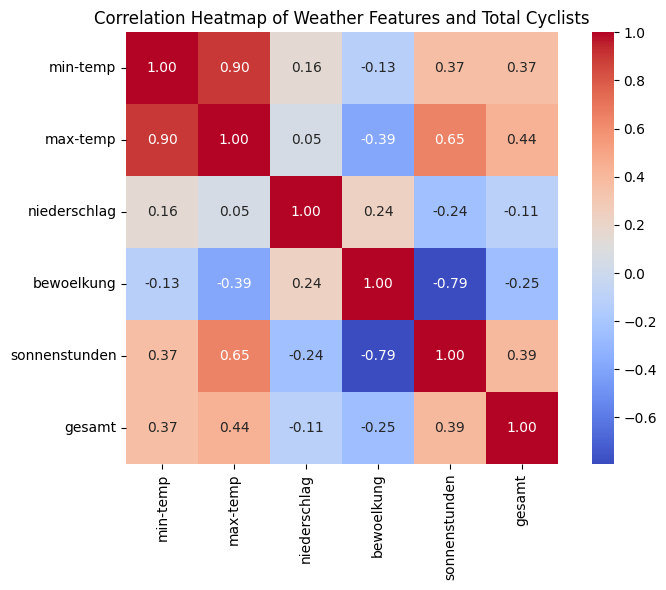

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric columns
corr_features = ['min-temp', 'max-temp', 'niederschlag', 'bewoelkung', 'sonnenstunden', 'gesamt']

# Compute correlation matrix
corr_matrix = df[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Weather Features and Total Cyclists")
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the dataset: create a new dataframe with relevant columns
df_days = df[['sonnenstunden', 'niederschlag', 'bewoelkung', 'gesamt', 'zaehlstelle']]

# Rename columns for easier access
df_days.rename(columns={
    'sonnenstunden': 'sun_hours',
    'niederschlag': 'precipitation',
    'bewoelkung': 'cloud_cover_perc',
    'gesamt': 'total',
    'zaehlstelle': 'measuring_station'
}, inplace=True)

# Create a pairplot
sns.pairplot(df_days[['sun_hours', 'precipitation', 'cloud_cover_perc', 'total', 'measuring_station']],
             hue='measuring_station',
             plot_kws=dict(alpha=0.25, s=5),
             diag_kws=dict(alpha=0.25))

plt.show()


<ipython-input-20-fd2314beef50>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### **Global Terrorism Database** - Property Damage Estimation

#### **Dataset Overview**

We will utilize the Global Terrorism Database (GTD) curated by START (National Consortium for the Study of Terrorism and Responses to Terrorism), which contains comprehensive information on over 180,000 terrorist incidents worldwide from 1970 to 2017. The dataset includes variables such as the date and location of the incident, weapon types, target types, responsible groups, number of casualties, and property damage information.

Key features include:

*   Temporal data: year, month and day of the incident
*   Geospatial data: country, region and city
*   Incident characteristics : attack type, target type, weapon type
*   Casualty information: number of people killed or wounded
*   Property damage indicators: whether property damage occurred, extent,  
    and estimated value








#### **Project Objectives**

This project aims to build a two-stage machine learning system capable of:


*  **Classifying** whether a terrorist incident will cause property damage (**binary classification**).
* **Estimating** the severity of property damage when it occurs (**ordinal classification or regression**).

These predictions can support risk assessment, emergency preparedness, and infrastructure protection strategies by identifying which types of terrorist events are more likely to cause material losses.




**Methodolgy**
We propose the following two-step modeling pipeline:


**Step 1: Property Damage Occurrence Prediction**

*   **Target**: `property` (binary: 1 = damage, 0 = no damage)
*   **Model**: Logistic Regression or Gradient Boosting Classifier
*   **Goal**: Predict whether a terrorist attack will result in any property damage.



**Step 2: Property Damage Severity Prediction**

* **Target Options**:
  * `properxtent` (ordinal classification: e.g., minor to major damage), or
  * `propvalue`  (regression if value is available)

* **Model Options**:
  * Random Forest classifer (for `propextent`)
  * XGBoost Regressor or Linear Regression (for `propvalue`)

* **Goal**: Estimate the extent or monetary value of property damage for incidents where damage occurs.

#### **Loading the Data**


In [ ]:
# Install dependencies as needed:
# !pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "globalterrorismdb_0718dist.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "START-UMD/gtd",
  file_path,
  pandas_kwargs={"encoding": "ISO-8859-1"}
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



In [ ]:
# print("First 5 records:", df.head())

#### **Exploratory Data Analysis & Visualization**

To understand and visualize delay patterns, the following analyses will be conducted:

1. **Temporal Patterns:**
   - Line chart: Total incidents vs. incidents with property damage per year
   - Area chart: Extent of damage (propextent) over time (later)

2. **Geographical Patterns:**
   - World map (choropleth): Count or intensity of property damage by country (temporary graph)

3. **Categorical Breakdown:**
   - Treemap: Target types by damage extent.
   - Grouped bar chart: Attack types vs. frequency of property damage

#### **Dataset Visualizations**

---

**Temporal Patterns**

In [ ]:
import matplotlib.pyplot as plt

# Use the already-loaded df from kagglehub
df_year = df[['iyear', 'property']].copy()
df_year['property'] = df_year['property'].fillna(0)

# Aggregate
damage_by_year = df_year.groupby('iyear')['property'].sum()
attacks_by_year = df_year.groupby('iyear')['property'].count()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(attacks_by_year.index, attacks_by_year.values, label='Total Attacks')
plt.plot(damage_by_year.index, damage_by_year.values, label='Attacks with Property Damage')
plt.title("Terrorist Attacks vs Property Damage Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Geospatial Analysis**

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load world shapefile directly from Natural Earth via GeoPandas
world = gpd.read_file("https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson")

# Prepare terrorism data for merging
df_geo = df[['country_txt', 'property']].copy()
df_geo['property'] = df_geo['property'].fillna(0)
country_damage = df_geo.groupby('country_txt')['property'].sum().reset_index()

# Merge on country name
world = world.merge(country_damage, how='left', left_on='NAME', right_on='country_txt')
world['property'] = world['property'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(column='property', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title("Property Damage by Country (1970–2017)")
ax.axis('off')
plt.show()


**Categorical Analysis**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the relevant columns and clean data
df_cat = df[['attacktype1_txt', 'property']].copy()
df_cat['property'] = df_cat['property'].fillna(0)

# Group by attack type and sum property damage occurrences
attack_damage = df_cat.groupby('attacktype1_txt')['property'].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=attack_damage.values, y=attack_damage.index, palette='viridis')

plt.title("Total Property Damage by Attack Type", fontsize=14)
plt.xlabel("Number of Incidents with Property Damage")
plt.ylabel("Attack Type")
plt.tight_layout()
plt.show()


-----**ITS STILL NOT DONE NEED SOME CHANGES IN THE GRAPHS**-----

## **Part 3:** Project Implementation - Whatever _(draft)_

### **3.1** Loading The Data

### **3.2** Training and Test Data

### **3.3** Model Fitting

### **3.4** Prediction

### **3.5** Preprocessing The Data

**Standardization**

**Normalization**

**Binazation**

**Encoding Categorical Features**

**Inputing Missing Values**

**Generating Polynomial Features**

#### 3.6 Creating The Model

#### 3.7 Performance Evaluation

**Classification Metrics**

**Regression Metrics**